Skewness of Delivery Delay: 2.30
Cramér’s V (Rework vs Delay): 0.86
Entropy of Rejection Reasons: 0.64
Variance in Cost/Unit → Rejected: ₹89084.92, Non-Rejected: ₹1793485.48
Pearson Correlation (Internal Loss vs Profit): 0.98
Spearman Correlation (Delay vs Cost/Unit): 0.05
Outlier Count in Rejected Orders (Cost/Unit): 0


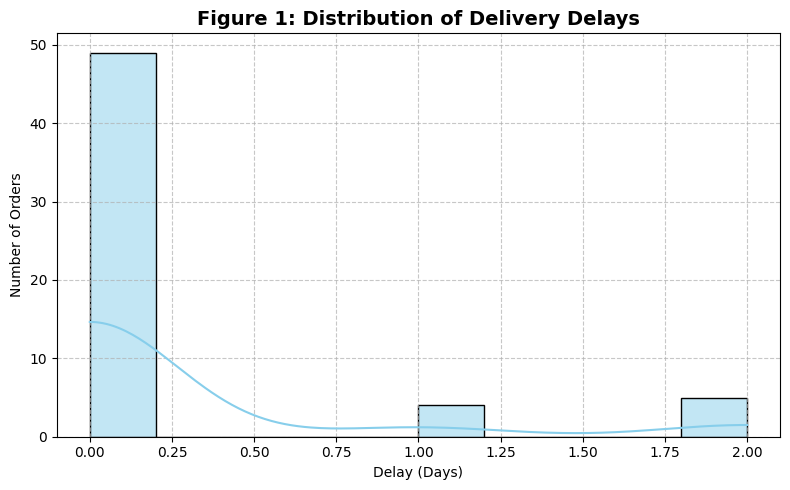

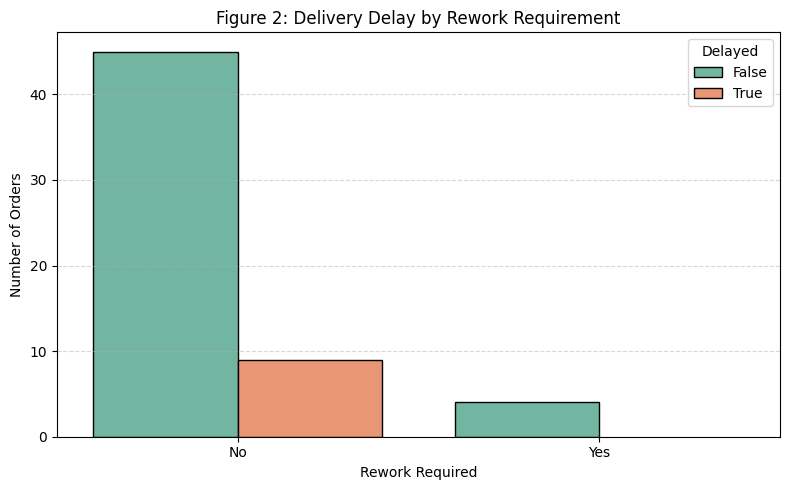

/tmp/ipython-input-1-1021494890.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rejected, y='Rejection Reason',


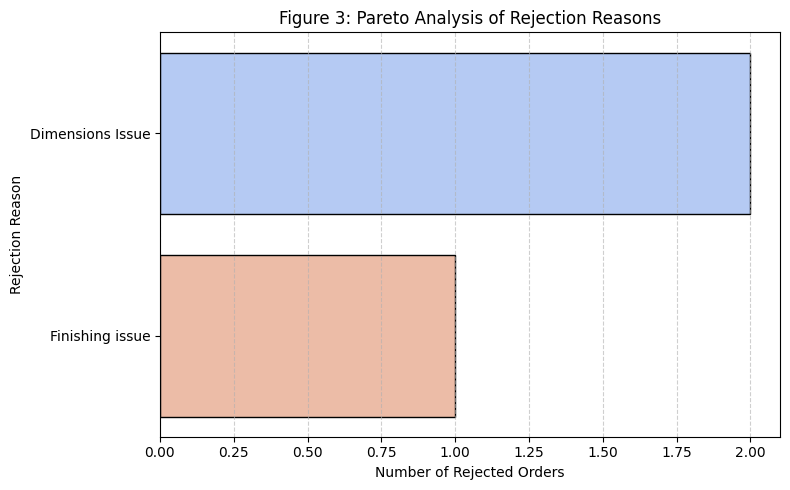

/tmp/ipython-input-1-1021494890.py:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Rejected', y='Cost_Per_Unit', palette='Set3')


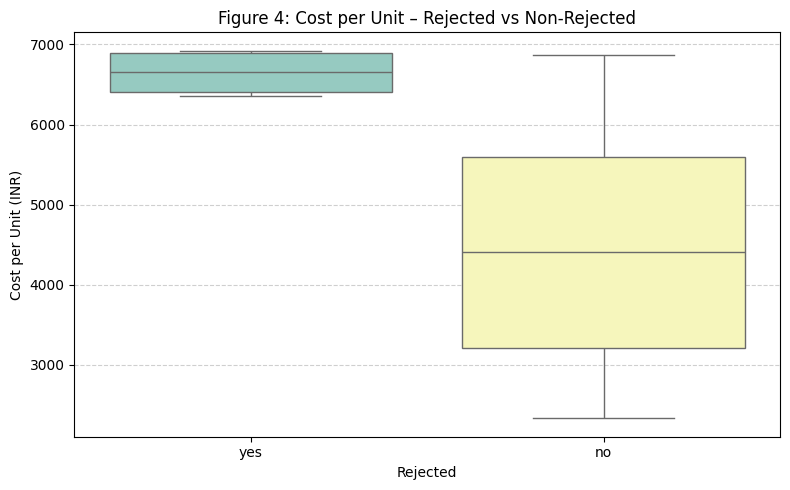

<Figure size 800x500 with 0 Axes>

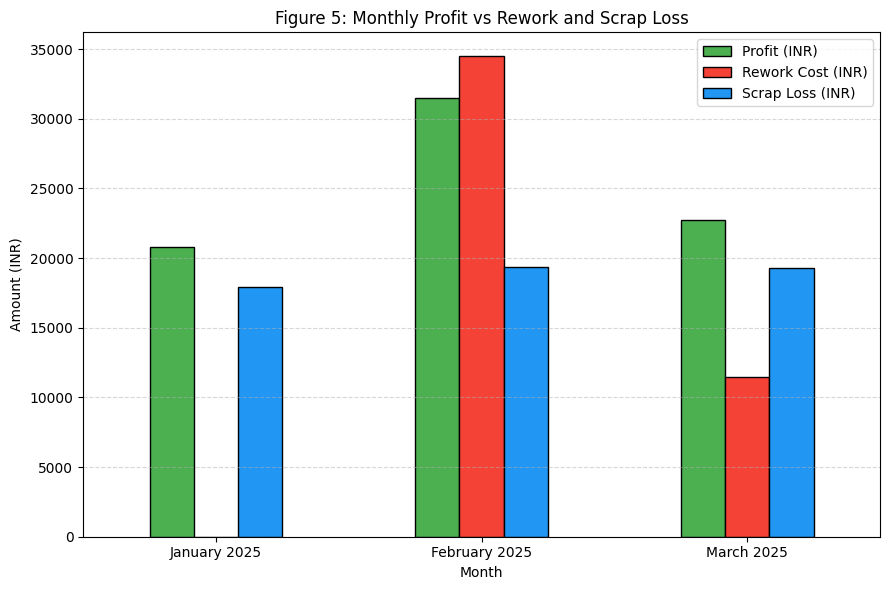

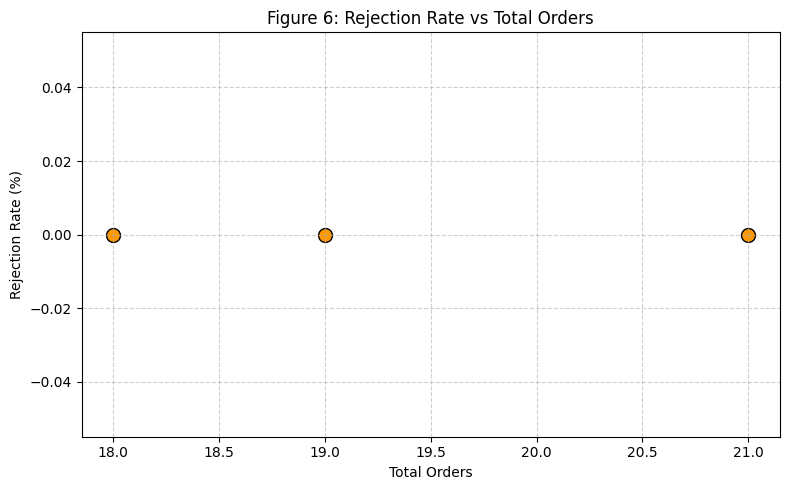

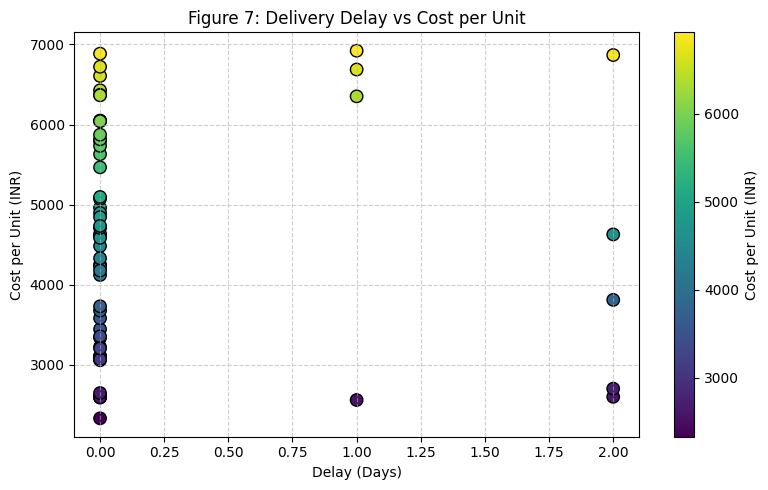

In [1]:
# --- Step 1: Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, skew, entropy, pearsonr
from sklearn.preprocessing import LabelEncoder

# --- Step 2: Load Data ---
df = pd.read_csv('Manufacturing_Data_3_Months_final(1).xlsx - Orders.csv')
finance = pd.read_csv('Manufacturing_Data_3_Months_final(1).xlsx - Monthly Financials.csv')

# --- Step 3: Preprocessing ---
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Month'] = df['Order Date'].dt.strftime('%B')
df['Cost_Per_Unit'] = df['Total Order Cost (INR)'] / df['Quantity']
df['Rejected'] = df['Rejected'].astype(str).str.strip().str.lower()
df['Rework Required'] = df['Rework Required'].astype(str).str.strip().str.capitalize()
df['Delayed'] = df['Delay (Days)'] > 0

# --- Step 4: Statistical Measures ---
skewness_delay = skew(df['Delay (Days)'])
print(f"Skewness of Delivery Delay: {skewness_delay:.2f}")

# Cramer's V (Rework Required vs Delayed)
rework_encoded = LabelEncoder().fit_transform(df['Rework Required'])
delay_encoded = LabelEncoder().fit_transform(df['Delayed'])
contingency = pd.crosstab(rework_encoded, delay_encoded)
chi2 = ((contingency - contingency.mean()) ** 2 / contingency.mean()).sum().sum()
n = contingency.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(contingency.shape)-1)))
print(f"Cramér’s V (Rework vs Delay): {cramers_v:.2f}")

# Entropy of Rejection Reason
rejected = df[df['Rejected'] == 'yes']
p = rejected['Rejection Reason'].value_counts(normalize=True)
ent = entropy(p)
print(f"Entropy of Rejection Reasons: {ent:.2f}")

# Variance in cost/unit for rejected vs non-rejected
var_rejected = df[df['Rejected'] == 'yes']['Cost_Per_Unit'].var()
var_nonrejected = df[df['Rejected'] != 'yes']['Cost_Per_Unit'].var()
print(f"Variance in Cost/Unit → Rejected: ₹{var_rejected:.2f}, Non-Rejected: ₹{var_nonrejected:.2f}")

# Pearson correlation: Internal loss vs Profit
internal_loss = finance['Rework Cost (INR)'] + finance['Scrap Loss (INR)']
profit = finance['Profit (INR)']
pearson_corr = pearsonr(internal_loss, profit)[0]
print(f"Pearson Correlation (Internal Loss vs Profit): {pearson_corr:.2f}")

# Spearman correlation: Delay vs Cost/Unit
spearman_corr, _ = spearmanr(df['Delay (Days)'], df['Cost_Per_Unit'])
print(f"Spearman Correlation (Delay vs Cost/Unit): {spearman_corr:.2f}")

# Outlier Detection for rejected orders
q1 = rejected['Cost_Per_Unit'].quantile(0.25)
q3 = rejected['Cost_Per_Unit'].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
outliers = rejected[(rejected['Cost_Per_Unit'] < lower) | (rejected['Cost_Per_Unit'] > upper)]
print(f"Outlier Count in Rejected Orders (Cost/Unit): {len(outliers)}")

# --- Step 5: Monthly Rejection Rate ---
monthly_rejections = df[df['Rejected'] == 'yes'].groupby('Month').size().reset_index(name='Rejected Orders')
finance = pd.merge(finance, monthly_rejections, on='Month', how='left')
finance['Rejected Orders'] = finance['Rejected Orders'].fillna(0)
finance['Rejection_Rate'] = (finance['Rejected Orders'] / finance['Total Orders']) * 100

# --- Step 6: Graphs (Visually Enhanced) ---

# Figure 1: Delivery Delay Distribution
plt.figure(figsize=(8,5))
sns.histplot(df['Delay (Days)'], bins=10, kde=True, color='skyblue', edgecolor='black')
plt.title('Figure 1: Distribution of Delivery Delays', fontsize=14, weight='bold')
plt.xlabel('Delay (Days)')
plt.ylabel('Number of Orders')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Figure 2: Delay by Rework Required
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Rework Required', hue='Delayed', palette='Set2', edgecolor='black')
plt.title('Figure 2: Delivery Delay by Rework Requirement')
plt.xlabel('Rework Required')
plt.ylabel('Number of Orders')
plt.legend(title='Delayed')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Figure 3: Rejection Reasons
plt.figure(figsize=(8,5))
sns.countplot(data=rejected, y='Rejection Reason',
              order=rejected['Rejection Reason'].value_counts().index,
              palette='coolwarm', edgecolor='black')
plt.title('Figure 3: Pareto Analysis of Rejection Reasons')
plt.xlabel('Number of Rejected Orders')
plt.ylabel('Rejection Reason')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Figure 4: Cost per Unit - Rejected vs Non-Rejected
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Rejected', y='Cost_Per_Unit', palette='Set3')
plt.title('Figure 4: Cost per Unit – Rejected vs Non-Rejected')
plt.xlabel('Rejected')
plt.ylabel('Cost per Unit (INR)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Figure 5: Profit vs Internal Losses
plt.figure(figsize=(8,5))
finance.set_index('Month')[['Profit (INR)', 'Rework Cost (INR)', 'Scrap Loss (INR)']].plot(
    kind='bar', figsize=(9,6), color=['#4caf50','#f44336','#2196f3'], edgecolor='black')
plt.title('Figure 5: Monthly Profit vs Rework and Scrap Loss')
plt.ylabel('Amount (INR)')
plt.xlabel('Month')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Figure 6: Rejection Rate vs Order Volume
plt.figure(figsize=(8,5))
plt.scatter(finance['Total Orders'], finance['Rejection_Rate'],
            color='#ff9800', edgecolors='black', s=100)
plt.title('Figure 6: Rejection Rate vs Total Orders')
plt.xlabel('Total Orders')
plt.ylabel('Rejection Rate (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Figure 7: Delay vs Cost per Unit
plt.figure(figsize=(8,5))
plt.scatter(df['Delay (Days)'], df['Cost_Per_Unit'],
            c=df['Cost_Per_Unit'], cmap='viridis', s=80, edgecolor='black')
plt.title('Figure 7: Delivery Delay vs Cost per Unit')
plt.xlabel('Delay (Days)')
plt.ylabel('Cost per Unit (INR)')
plt.colorbar(label='Cost per Unit (INR)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

